In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

# Read the CSV and Perform Basic Data Cleaning

In [4]:
# https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [5]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv.zip')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# Split the Data into Training and Testing

In [6]:
#remove columns with only 1 value
df = df.drop(columns = ['pymnt_plan', 'hardship_flag'])
df = df.drop(columns = ['debt_settlement_flag', 'recoveries', 'collection_recovery_fee', 'acc_now_delinq', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'policy_code', 'next_pymnt_d','tax_liens'])

#Ecode variables using `LabelEncoder` from sklearn.preprocessing, after which we instantiate the `LabelEncoder()` object, then run a `.fit()` followed by `.transform()`. The results are stored in a new variable `encoded_y` and inserted into the DataFrame.

#ndividual    59206
#Joint App      9611
#Name: application_type

#May-2019    42449
#Apr-2019    26368
#Name: next_pymnt_d, dtype: int64

# MORTGAGE    36219
# RENT        24613
# OWN          7346
# ANY           639
# Name: home_ownership, dtype: int6
        
# Not Verified       32895
# Source Verified    25737
# Verified           10185
# Name: verification_status, dtype: int64
        
# Jan-2019    31041
# Feb-2019    25579
# Mar-2019    12197
# Name: issue_d, dtype: int64

# w    60292
# f     8525
# Name: initial_list_status, dtype: int64

from sklearn.preprocessing import LabelEncoder

columns_to_encode = ['initial_list_status', 'issue_d', 'home_ownership','verification_status', 'application_type']  #, 'next_pymnt_d'

for column in columns_to_encode:
    encoder = LabelEncoder()
    encoder.fit(df[column])
    encoded_x = encoder.transform(df[column])
    df[f'Encoded_{column}'] = encoded_x

df = df.drop(columns = columns_to_encode)
df.columns

Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'loan_status',
       'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'last_pymnt_amnt', 'collections_12_mths_ex_med',
       'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il',
       'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il',
       'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
       'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_re

In [7]:
# Create our features
X = df.drop(columns='loan_status')

# Create our target
y = df['loan_status'].to_frame()

In [8]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,Encoded_initial_list_status,Encoded_issue_d,Encoded_home_ownership,Encoded_verification_status,Encoded_application_type
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,6.881700e+04,6.881700e+04,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.125972,2.100332e+05,6.133843e+04,29734.128558,5.572240e+04,0.876121,0.805542,1.812779,0.669994,0.139660
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.336732,1.928088e+05,5.738798e+04,26795.394232,5.095845e+04,0.329446,0.714932,0.941313,0.719105,0.346637
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,3.600000e+03,2.350000e+02,100.000000,1.270000e+02,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,6.697700e+04,2.650300e+04,11600.000000,2.288000e+04,1.000000,0.000000,1.000000,0.000000,0.000000
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.467100e+05,4.535700e+04,22100.000000,4.200000e+04,1.000000,1.000000,1.000000,1.000000,0.000000
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,3.036400e+05,7.657000e+04,39300.000000,7.249900e+04,1.000000,1.000000,3.000000,1.000000,0.000000
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,4.000000,3.292782e+06,1.295455e+06,509400.000000,1.426964e+06,1.000000,2.000000,3.000000,2.000000,1.000000


In [9]:
# Check the balance of our target values
y['loan_status'].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [10]:
# Split the X and y into X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, stratify = y)

# Data scaling before using Random forrest

In [15]:
from sklearn.preprocessing import StandardScaler

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble AdaBoost classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Print the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier onely, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [24]:
# Resample the training data with the Random Forrest Classifier
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators = 500,random_state=1)
rfc.fit(X_train_scaled, y_train)
predictions = rfc.predict(X_test_scaled)

In [25]:
# Calculated the balanced accuracy score

from sklearn.metrics import balanced_accuracy_score

# Calculating the accuracy score
acc_score = balanced_accuracy_score(y_test, predictions)
acc_score


0.6605690319929415

In [27]:
# Display the confusion matrix

cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual High risk", "Actual Low Risk"], columns=["Predicted High Risk", "Predicted Low Risk"])

print("Confusion Matrix")
display(cm_df)

Confusion Matrix


,Predicted High Risk,Predicted Low Risk
Actual High risk,28,59
Actual Low Risk,12,17106


In [22]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, predictions))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.70      0.32      1.00      0.44      0.57      0.30        87
   low_risk       1.00      1.00      0.32      1.00      0.57      0.34     17118

avg / total       1.00      1.00      0.33      1.00      0.57      0.34     17205



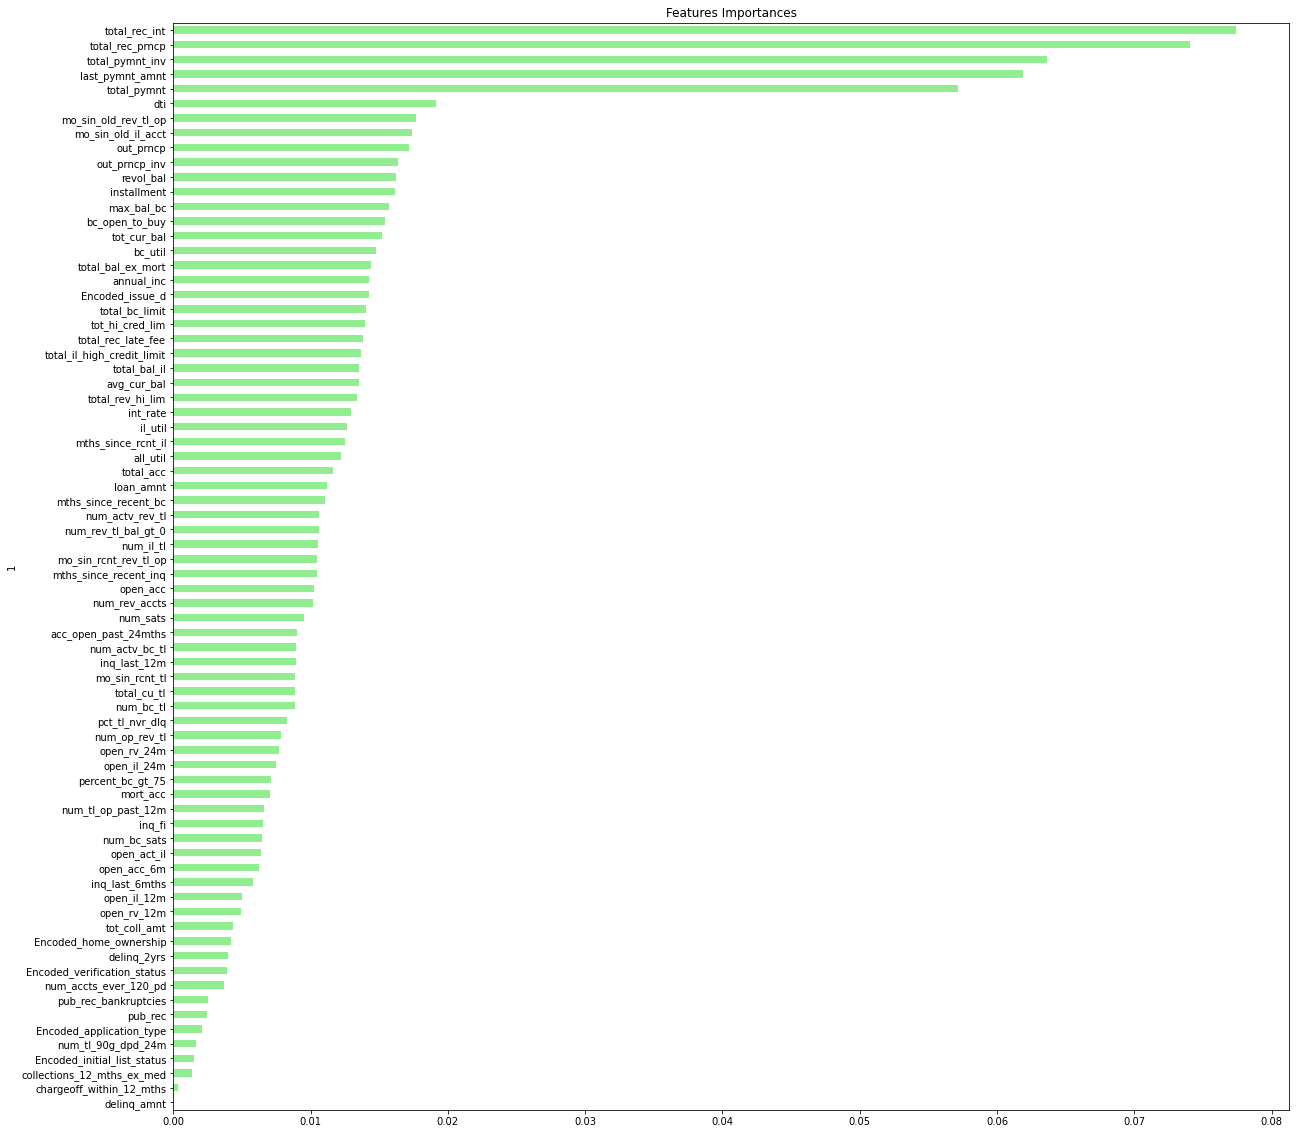

In [30]:
# List the features sorted in descending order by feature importance
importances = rfc.feature_importances_

importances_df = pd.DataFrame(sorted(zip(rfc.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False, figsize = (20,20))



### Easy Ensemble AdaBoost Classifier

In [32]:
# Train the Classifier
from sklearn.ensemble import AdaBoostClassifier

ada_boost_classifier = AdaBoostClassifier(n_estimators=100, random_state=1)
ada_boost_classifier.fit(X_train_scaled, y_train)

predictions_abc = ada_boost_classifier.predict(X_test_scaled)

In [34]:
# Calculated the balanced accuracy score
acc_score_abc = balanced_accuracy_score(y_test, predictions_abc)
acc_score_abc

0.6435613248405591

In [35]:
# Display the confusion matrix

cm_abc= confusion_matrix(y_test, predictions_abc)
cm_df_abc = pd.DataFrame(
    cm_abc, index=["Actual High risk", "Actual Low Risk"], columns=["Predicted High Risk", "Predicted Low Risk"])

print("Confusion Matrix")
display(cm_df_abc)

Confusion Matrix


,Predicted High Risk,Predicted Low Risk
Actual High risk,25,62
Actual Low Risk,4,17114


In [36]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, predictions_abc))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.86      0.29      1.00      0.43      0.54      0.27        87
   low_risk       1.00      1.00      0.29      1.00      0.54      0.31     17118

avg / total       1.00      1.00      0.29      1.00      0.54      0.31     17205



# Retrain RandomForrestClassifier with only significant features

In [38]:
sorted(zip(rfc.feature_importances_, X.columns), reverse = True)


[(0.07741762295504592, 'total_rec_int'),
 (0.07402598822367602, 'total_rec_prncp'),
 (0.0636521779214723, 'total_pymnt_inv'),
 (0.06189756154099104, 'last_pymnt_amnt'),
 (0.05715739108514619, 'total_pymnt'),
 (0.01914420718914076, 'dti'),
 (0.01766189618102784, 'mo_sin_old_rev_tl_op'),
 (0.01735865664519227, 'mo_sin_old_il_acct'),
 (0.017157111940794435, 'out_prncp'),
 (0.01640079826305078, 'out_prncp_inv'),
 (0.01622770046959414, 'revol_bal'),
 (0.016112856160813736, 'installment'),
 (0.015725266224911057, 'max_bal_bc'),
 (0.01542155914038692, 'bc_open_to_buy'),
 (0.015191522462805704, 'tot_cur_bal'),
 (0.01474222063939141, 'bc_util'),
 (0.014432503390702588, 'total_bal_ex_mort'),
 (0.014275434302744115, 'annual_inc'),
 (0.014223342005052571, 'Encoded_issue_d'),
 (0.014031451698193984, 'total_bc_limit'),
 (0.013981575088451815, 'tot_hi_cred_lim'),
 (0.013851141545466529, 'total_rec_late_fee'),
 (0.013696863981753163, 'total_il_high_credit_limit'),
 (0.013543583581829713, 'total_bal_il

In [40]:
#create a new set of independent vaiables

X_train_v = X_train[['total_rec_int', 'total_rec_prncp', 'total_pymnt_inv','last_pymnt_amnt', 'total_pymnt']]
X_test_v = X_test[['total_rec_int', 'total_rec_prncp', 'total_pymnt_inv','last_pymnt_amnt', 'total_pymnt']]

# Creating StandardScaler instance
scaler_v = StandardScaler()

# Fitting Standard Scaller
X_scaler_v = scaler_v.fit(X_train_v)

X_train_scaled_v = X_scaler_v.transform(X_train_v)
X_test_scaled_v = X_scaler_v.transform(X_test_v)

rfc_v = RandomForestClassifier(n_estimators = 500,random_state=1)
rfc_v.fit(X_train_scaled_v, y_train)
predictions_v = rfc_v.predict(X_test_scaled_v)

acc_score_v = balanced_accuracy_score(y_test, predictions_v)
print(acc_score_v)

cm_v = confusion_matrix(y_test, predictions)
cm_df_v = pd.DataFrame(
    cm_v, index=["Actual High risk", "Actual Low Risk"], columns=["Predicted High Risk", "Predicted Low Risk"])

print("Confusion Matrix")
display(cm_df_v)


0.6833822836215961
Confusion Matrix


,Predicted High Risk,Predicted Low Risk
Actual High risk,28,59
Actual Low Risk,12,17106


In [41]:
print(classification_report_imbalanced(y_test, predictions_v))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.64      0.37      1.00      0.47      0.61      0.34        87
   low_risk       1.00      1.00      0.37      1.00      0.61      0.39     17118

avg / total       0.99      1.00      0.37      1.00      0.61      0.39     17205

